In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2


file_name = 'ride_sharing.csv'



In [2]:
df = pd.read_csv(file_name)
df = df.dropna(subset="dropoff_time") # drop car agents

df


,RunId,iteration,Step,num_cars,width,height,multi_pass,seed_int,strategy,Manhattan,AgentID,Steps,IdleTime,request_time,pickup_time,dropoff_time
0,0,0,0,1,10,10,True,11,StepType.CLOSEST,0,1,NaN,NaN,0.0,-1.0,-1.0
2,0,0,1,1,10,10,True,11,StepType.CLOSEST,0,1,NaN,NaN,0.0,-1.0,-1.0
4,0,0,2,1,10,10,True,11,StepType.CLOSEST,0,1,NaN,NaN,0.0,-1.0,-1.0
6,0,0,3,1,10,10,True,11,StepType.CLOSEST,0,1,NaN,NaN,0.0,2.0,-1.0
8,0,0,4,1,10,10,True,11,StepType.CLOSEST,0,1,NaN,NaN,0.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995773,449,4,1999,5,10,10,True,221,StepType.QUEUE,0,807,NaN,NaN,1990.0,-1.0,-1.0
5995774,449,4,1999,5,10,10,True,221,StepType.QUEUE,0,808,NaN,NaN,1995.0,-1.0,-1.0
5995780,449,4,2000,5,10,10,True,221,StepType.QUEUE,0,807,NaN,NaN,1990.0,-1.0,-1.0
5995781,449,4,2000,5,10,10,True,221,StepType.QUEUE,0,808,NaN,NaN,1995.0,-1.0,-1.0


In [3]:
f_rates = pd.DataFrame()

fulfilled = df[df["dropoff_time"] != -1] # passengers whose requests were fulfilled
unique_fulfilled = fulfilled.drop_duplicates(subset=['seed_int', 'iteration', 'num_cars', 'strategy', 'AgentID'])

unique_df = df.drop_duplicates(subset=['seed_int', 'iteration', 'num_cars', 'strategy', 'AgentID'], keep='last')


for strategy in ["StepType.CLOSEST", "StepType.QUEUE", "StepType.WAITING"]:
    for i in range(1,6):

        num_fulfilled = len(unique_fulfilled[(unique_fulfilled["strategy"] == strategy) & (unique_fulfilled["num_cars"] == i)])

        total = len(unique_df[(unique_df["strategy"] == strategy) & (unique_df["num_cars"] == i)])

        f_rate = (num_fulfilled/total) * 100

        f_rates = f_rates.append({'Strategy': strategy, 'num_cars': i, 'f_rate': f_rate}, ignore_index=True)


f_rates

C:\Users\lokhe\AppData\Local\Temp\ipykernel_2436\3554678441.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f_rates = f_rates.append({'Strategy': strategy, 'num_cars': i, 'f_rate': f_rate}, ignore_index=True)
C:\Users\lokhe\AppData\Local\Temp\ipykernel_2436\3554678441.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f_rates = f_rates.append({'Strategy': strategy, 'num_cars': i, 'f_rate': f_rate}, ignore_index=True)
C:\Users\lokhe\AppData\Local\Temp\ipykernel_2436\3554678441.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f_rates = f_rates.append({'Strategy': strategy, 'num_cars': i, 'f_rate': f_rate}, ignore_index=True)
C:\Users\lokhe\AppData\Local\Temp\ipykernel_2436\3554678441.py:18: FutureWarning: The frame

,Strategy,num_cars,f_rate
0,StepType.CLOSEST,1,50.847880
1,StepType.CLOSEST,2,85.580431
2,StepType.CLOSEST,3,97.162945
3,StepType.CLOSEST,4,97.970297
4,StepType.CLOSEST,5,98.057613
5,StepType.QUEUE,1,50.058188
6,StepType.QUEUE,2,84.585406
7,StepType.QUEUE,3,97.510339
8,StepType.QUEUE,4,98.275578
9,StepType.QUEUE,5,98.181070


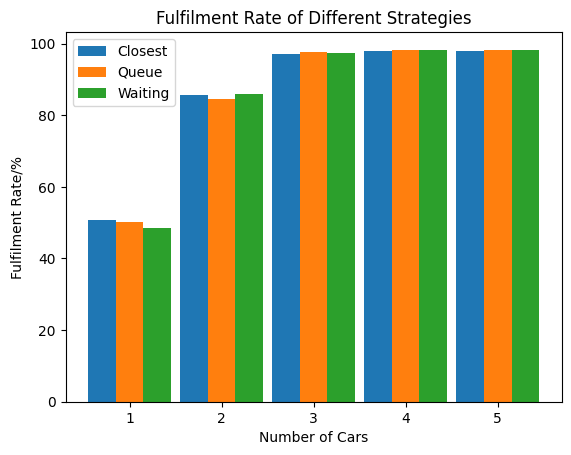

In [4]:
f_rates

# Generate some example data
labels = [i for i in range (1,6)]
f_rates_list = f_rates['f_rate'].tolist()
closest = f_rates_list[:5]
queue = f_rates_list[5:10]
waiting = f_rates_list[10:]

# Define the bar width
bar_width = 0.3

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the first group of bars
ax.bar(np.arange(len(labels)), closest, width=bar_width, label='Closest')

# Plot the second group of bars, shifted to the right
ax.bar(np.arange(len(labels)) + bar_width, queue, width=bar_width, label='Queue')

ax.bar(np.arange(len(labels)) + 2 * bar_width, waiting, width=bar_width, label='Waiting')


# Set the x-axis labels and tick marks
ax.set_xticks(np.arange(len(labels)) + bar_width)
ax.set_xticklabels(labels)

# Add a legend
ax.legend()

plt.xlabel('Number of Cars')
plt.ylabel('Fulfilment Rate/%')
plt.title('Fulfilment Rate of Different Strategies')

# Display the plot
plt.savefig('figures/f_rate.png')

